<span style="font-size:24px; font-family:'Arial bold'; color:darkblue;">
Four tools useful for handling phase-field simulation (Fig.4)
</span>


In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from langchain_ollama import ChatOllama
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from langchain.schema import AIMessage


In [2]:
#Numerical parameter values
PI = 3.141592 #π
RR = 8.3145 #Gas constant [J／（mol K）]

#Setting materials and process constants
ND = 128  #Dividing number in the difference method

#c0 = 0.5 #Alloy composition （moll fraction of Cr）
al = 100.0*1.e-9 #Side length of 2-dimensional simulation area [m]
b1 = al/ND #1 block size in the difference method [m]

#These are not a real time but an increment
itime1 = 0 #Initial time ）
itime1max = 10000 + 1 #Time to stop the simulation
itime1_step = 1000 #Time step to save the field data

#Fluctuation factor
c_flu_ini=0.01 #Fluctuation factor in initial field
c_flu=0.0 #Fluctuation factor in dcdt

#Output folder
output_folder = "Phase_decomp_RSA_out/"
os.makedirs(output_folder, exist_ok=True)


In [3]:
# Definition of tool
@tool
# Definition of tool
def Check_phase_field_simulation_RSA(aging_temp1: float, alloy_comp1: float, time_step1: float)-> int:
    """
    This is a check version of the simulation.
    Performs a phase-field simulation of phase decomposition in A-B binary alloy with regular solution approximation during isothermal aging.
    It receives three input parameters: aging temperature with the unit K, alloy composition with atomic fraction B component,
    and dimensionless time step. 
    The phase-field simulation is performed, and the calculation results (simulated field images) are displied on screen. 
    Finally, it returns the end status of the calculation as an int type. When the value of the end status is 0, the calculation fails, 
    and when the value of the end status is 1, the calculation succeeds.

    Args:
        temp1 (float): temperature, a float type input parameter, unit is K.
        comp1 (float): alloy composition, a float type input parameter, atomic fraction of B component.
        time_step1 (float): time step, a float type input parameter, dimensionless value.

    Returns:
        iflg (int): end status of the calculation.
    """
    
    temp=aging_temp1  
    c0=alloy_comp1 
    delt=time_step1 

    Rtemp = RR*temp # ＲＴ [J/mol]
 
    iflg=0    

    L0=25000.0/Rtemp #Interaction parameter [J/mol]
    kappa = 5.0e-15/b1** 2/Rtemp #Composition gradient energy coefficient, Normalized to b1 and RT[Jm^2/mol]/b1^2/RT]
    Mc=c0*(1.0-c0) #Mobility of atomic diffusion (dimensionless)

    #Simulation of spinodal decomposition
    c2 = c0 + c_flu_ini*(2.0*np.random.rand(ND, ND)-1.0)  #Initial field setting

    for itime1 in range(itime1max):  #loop
        c1 =1.0 - c2
        time1=delt*itime1 #time（dimensionless）

        mu_chem=L0*(c1-c2)+np.log(c2)-np.log(c1) #chemical potential difference
        mu_grad=-2.0*kappa*(np.roll(c2,1,0) + np.roll(c2,-1,0) + np.roll(c2,1,1) + np.roll(c2,-1,1) - 4.0*c2) #Concentration gradient potential
        mu = mu_chem+mu_grad
        mu_dev = np.roll(mu,1,0) + np.roll(mu,-1,0) + np.roll(mu,1,1) + np.roll(mu,-1,1) - 4.0*mu

        dcdt = Mc*mu_dev  #Nonlinear diffusion equation
        c2n = c2 + ( dcdt+ c_flu*(2.0*np.random.rand(ND)-1.0) )*delt  #Explicit-difference method
        res = c2n - (np.mean(c2n) - c0)  #Correction for average composition
        c2 = np.clip(res, 1.0e-06, 1.0-1.0e-06)  #Correction of composition range

        #Drawing field data
        if(itime1 % itime1_step) == 0:
            print('time =', time1)
            plt.clf() #clear drawing area
            plt.axis("off")
            plt.imshow(c2)  #Drawing composition field
            plt.clim(0, 1)  #Maximum and minimum color scale settings
            plt.pause(1.0)  #displayed for 1.0 sec
            #------------------------
            iflg=1
            
    return iflg

In [4]:
# Definition of tool
@tool
def Save_phase_field_simulation_RSA(index: int, aging_temp1: float, alloy_comp1: float, time_step1: float)-> int:
    """
    This is a save version of the simulation.
    Performs a phase-field simulation of phase decomposition in A-B binary alloy with regular solution approximation during isothermal aging.
    It receives four input parameters: file_index, aging temperature with the unit K, alloy composition with atomic fraction B component,
    and dimensionless time step. 
    The phase-field simulation is performed, and the calculation results (numerical information of the composition field) is saved on hard-disk drive. 
    Finally, it returns the end status of the calculation as an int type. When the value of the end status is 0, the calculation fails, 
    and when the value of the end status is 1, the calculation succeeds.

    Args:
        index (int): file index, an integer type input parameter.
        temp1 (float): temperature, a float type input parameter, unit is K.
        comp1 (float): alloy composition, a float type input parameter, atomic fraction of B component.
        time_step1 (float): time step, a float type input parameter, dimensionless value.

    Returns:
        iflg (int): end status of the calculation.
    """
    
    np.random.seed(index)

    temp=aging_temp1  
    c0=alloy_comp1 
    delt=time_step1 #delt = 0.2 #time increment [dimensionless]

    Rtemp = RR*temp # ＲＴ [J/mol]

    text_temp = str(temp)
    text_comp = str(c0)
    text_delt = str(delt)
    text_index = str(index)
    
    filename0 = f"PF_T{text_temp}_c{text_comp}_dt{text_delt}_No{text_index}"
    filename = f"{filename0}.csv"
    path = "./"+output_folder+filename

    iflg=0    

    L0=25000.0/Rtemp #Interaction parameter [J/mol]
    kappa = 5.0e-15/b1** 2/Rtemp #Composition gradient energy coefficient, Normalized to b1 and RT[Jm^2/mol]/b1^2/RT]
    Mc=c0*(1.0-c0) #Mobility of atomic diffusion (dimensionless)

    #Simulation of spinodal decomposition
    c2 = c0 + c_flu_ini*(2.0*np.random.rand(ND, ND)-1.0)  #Initial field setting

    for itime1 in range(itime1max):  #loop
        c1 =1.0 - c2
        time1=delt*itime1 #time（dimensionless）

        mu_chem=L0*(c1-c2)+np.log(c2)-np.log(c1) #chemical potential difference
        mu_grad=-2.0*kappa*(np.roll(c2,1,0) + np.roll(c2,-1,0) + np.roll(c2,1,1) + np.roll(c2,-1,1) - 4.0*c2) #Concentration gradient potential
        mu = mu_chem+mu_grad
        mu_dev = np.roll(mu,1,0) + np.roll(mu,-1,0) + np.roll(mu,1,1) + np.roll(mu,-1,1) - 4.0*mu

        dcdt = Mc*mu_dev  #Nonlinear diffusion equation
        c2n = c2 + ( dcdt+ c_flu*(2.0*np.random.rand(ND)-1.0) )*delt  #Explicit-difference method
        res = c2n - (np.mean(c2n) - c0)  #Correction for average composition
        c2 = np.clip(res, 1.0e-06, 1.0-1.0e-06)  #Correction of composition range

        #Save composition field
        if(itime1 % itime1_step) == 0:
            file = open(path, "a", newline='')
            writer0 = csv.writer(file, delimiter=',')
            writer0.writerow([time1])
            writer0.writerows(c2)
            file.close() #save_data(time1, c2)
            #------------------------
            iflg=1 #The field data is saved

    return iflg

In [5]:
# Definition of tool
@tool
def Load_data_display_images(Fname: str)-> int:
    """
    This is the image display version of simulated data.
    It receives the file name with string type, then load the simulated data from the hard disk drive and display images.
    Finally, it returns the end status of the imaging process as an int type. When the value of the end status is 0, the process fails, 
    and when the value of the end status is 1, the process succeeds.

    Args:
        Fname (str): file name, a str type input parameter.

    Returns:
        iflg (int): end status of the process.
    """
    
    iflg=0    
    rows = []

    filename = f"{Fname}.csv"
    path = "./"+output_folder+filename
    file = open(path, "r")
    reader0 = csv.reader(file, delimiter=',')
   
    i=0
    for row in reader0:
        rows.append(row);  i+=1
    Ndata=int(i/(ND+1))

    time0 = []
    cc = np.zeros((Ndata, ND, ND))
    for ii in range (Ndata):
        iii=ii*(ND+1)
        time0.append(float(rows[iii][0]))
        for i in range (ND):
            for j in range (ND):
                cc[ii][i][j] = (float(rows[iii+i+1][j]))

    for i in range (Ndata):
        time1 = time0[i]
        c = cc[i,:,:]

        print('time =', time1)
        plt.clf() # 描画内容クリア
        plt.imshow(c)  # 濃度場の描画
        plt.axis('off') 
        plt.clim(0, 1)  # カラースケールの最大、最小の設定
        plt.pause(1.0)  # 1.0秒間表示             
        iflg=1

    return iflg

In [6]:
# Definition of tool
@tool
def Load_data_save_images(Fname: str)-> int:
    """
    This is the image saving version of simulated data.
    It receives the file name with string type, then load the simulated data from the hard disk drive and save each image as an image file.
    Finally, it returns the end status of the imaging process as an int type. When the value of the end status is 0, the process fails, 
    and when the value of the end status is 1, the process succeeds.

    Args:
        Fname (str): file name, a str type input parameter.

    Returns:
        iflg (int): end status of the process.
    """
    
    iflg=0    
    rows = []

    filename = f"{Fname}.csv"
    path = "./"+output_folder+filename
    file = open(path, "r")
    reader0 = csv.reader(file, delimiter=',')
   
    i=0
    for row in reader0:
        rows.append(row);  i+=1
    Ndata=int(i/(ND+1))

    time0 = []
    cc = np.zeros((Ndata, ND, ND))
    for ii in range (Ndata):
        iii=ii*(ND+1)
        time0.append(float(rows[iii][0]))
        for i in range (ND):
            for j in range (ND):
                cc[ii][i][j] = (float(rows[iii+i+1][j]))

    for i in range (Ndata):
        time1 = time0[i]
        c = cc[i,:,:]

        print('time =', time1)
        plt.clf() # 描画内容クリア
        plt.imshow(c)  # 濃度場の描画
        plt.axis('off') 
        plt.clim(0, 1)  # カラースケールの最大、最小の設定

        fname="./"+output_folder+"image"+Fname+"_"+str(time1).replace(".", "")+".jpg"
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.0)
        plt.pause(1.0)  # 1.0秒間表示     
        iflg=1

    return iflg

In [7]:
tools = [Check_phase_field_simulation_RSA, Save_phase_field_simulation_RSA, Load_data_display_images, Load_data_save_images]
LLM = "qwen3:8b"
model = ChatOllama( 
    model=LLM, 
    temperature=0 
)
agent = create_react_agent( 
    model=model, 
    tools=tools 
)


time = 0.0


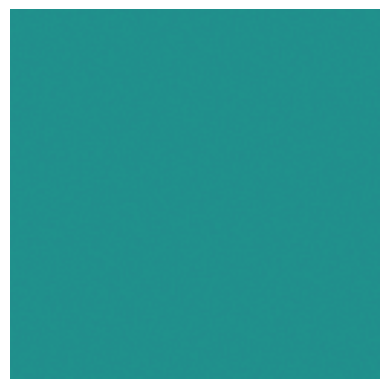

time = 20.0


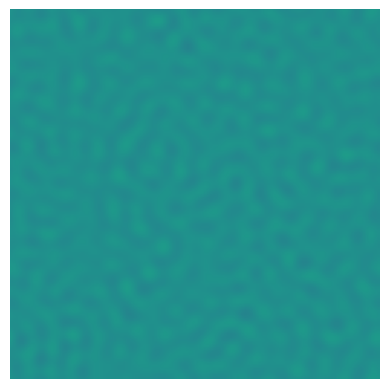

time = 40.0


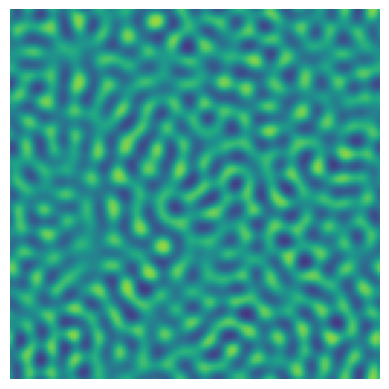

time = 60.0


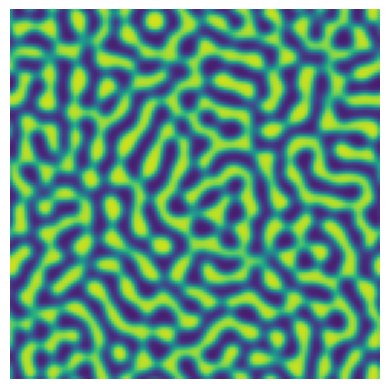

time = 80.0


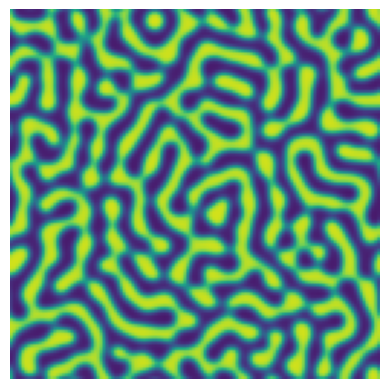

time = 100.0


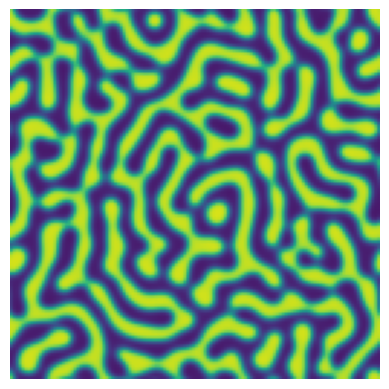

time = 120.0


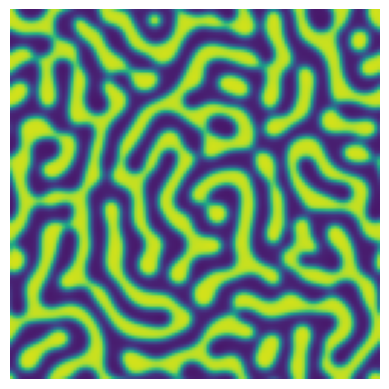

time = 140.0


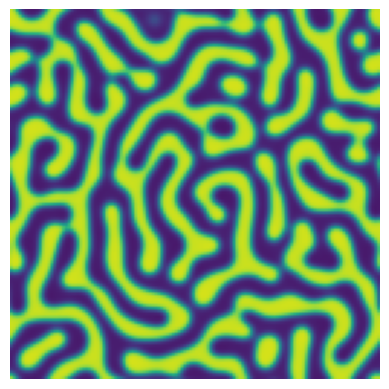

time = 160.0


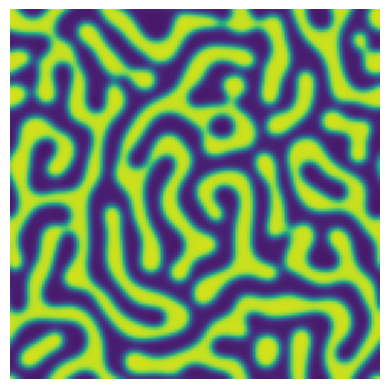

time = 180.0


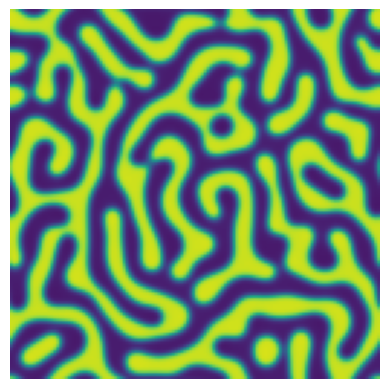

time = 200.0


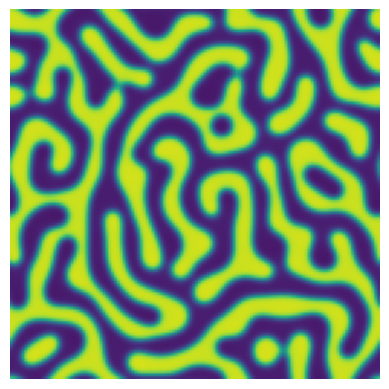


- <think>
Okay, let's see. The user wants me to fix the aging temperature at 1000 K, alloy composition to 0.5, and time step to 0.02. Then run the Check_phase_field_simulation_RSA tool.

First, I need to check the parameters required for that function. The Check_phase_field_simulation_RSA function needs aging_temp1, alloy_comp1, and time_step1. The user provided all three values: temp is 1000 K, comp is 0.5, time step is 0.02. So I should call the function with these parameters. 

Wait, the parameters are all floats. The user specified them correctly. No need for any conversion here. The function returns an int status. But the user just wants to run the simulation, so the tool call is straightforward. I'll structure the JSON with the correct parameter names and values. Let me double-check the parameter names in the function definition. Yes, they are aging_temp1, alloy_comp1, time_step1. So the arguments should be temp1: 1000, comp1: 0.5, time_step1: 0.02. 

No other functions are need

In [8]:
# Run the agent
messages = {
    "messages": [{"role": "user", "content": """Fix the aging temperature at 1000 K, fix the alloy composition to 0.5, and fix the time step to 0.02. 
               Under the above conditions, run the tool:'Check_phase_field_simulation_RSA'."""}]
}
answer = agent.invoke(messages)
messages_list = answer["messages"] # Get the messages list
filtered_messages = [msg.content for msg in messages_list if isinstance(msg, AIMessage)] # Extract assistant messages only.
formatted_output = "\n- " + "\n- ".join(filtered_messages) # Formatted and output
print(formatted_output)


In [14]:
# Run the agent
messages = {
    "messages": [{"role": "user", "content": """Fix the aging temperature at 1000 K, fix the alloy composition to 0.5, and fix the time step to 0.02. 
               Under the above conditions, changing the index number ranging from 1 to 50 in increments of 1, 
               run the tool: 'Save_phase_field_simulation_RSA' separately for each index number."""}]
}
answer = agent.invoke(messages)
messages_list = answer["messages"] # Get the messages list
filtered_messages = [msg.content for msg in messages_list if isinstance(msg, AIMessage)] # Extract assistant messages only.
formatted_output = "\n- " + "\n- ".join(filtered_messages) # Formatted and output
print(formatted_output)



- <think>
Okay, let's see. The user wants me to fix the aging temperature at 1000 K, alloy composition at 0.5, and time step at 0.02. Then, for each index from 1 to 50, run the Save_phase_field_simulation_RSA tool separately.

First, I need to understand the parameters for the Save_phase_field_simulation_RSA function. The required parameters are index, aging_temp1, alloy_comp1, and time_step1. The user has fixed temp1, comp1, and time_step1, so those values will be the same for each call. The index will vary from 1 to 50.

So, for each index in 1-50, I need to call the Save_phase_field_simulation_RSA function with the fixed parameters and the current index. That means 50 separate function calls. Each call will have the same temp, comp, and time step, but the index will increment by 1 each time.

I should check if there are any constraints on the index. The user says increments of 1, starting at 1 up to 50. So no issues there. Each call is independent, so I can loop through each index 

time = 0.0


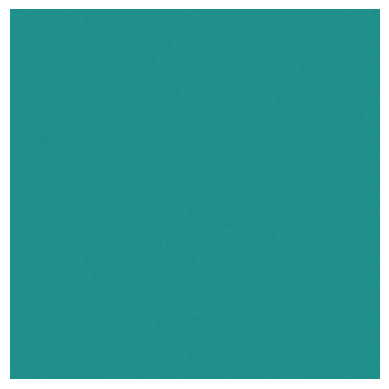

time = 20.0


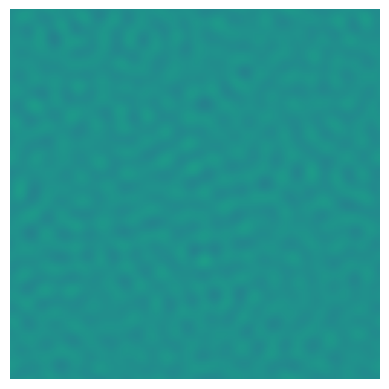

time = 40.0


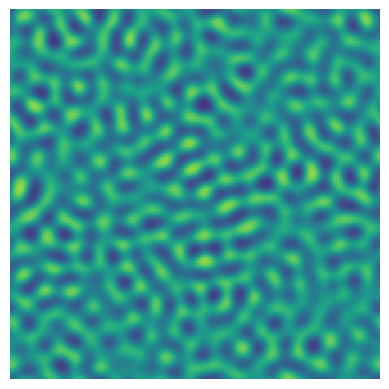

time = 60.0


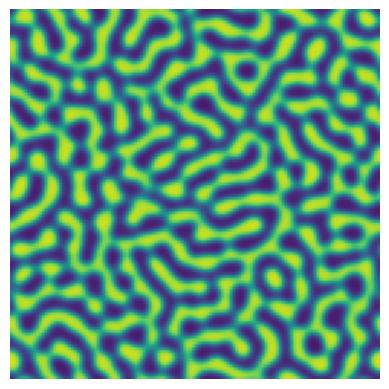

time = 80.0


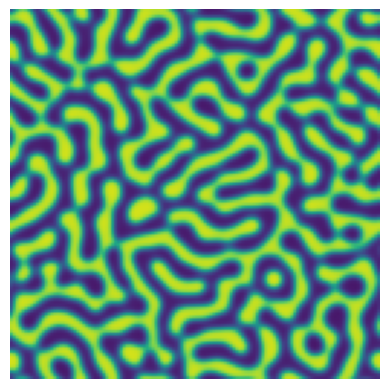

time = 100.0


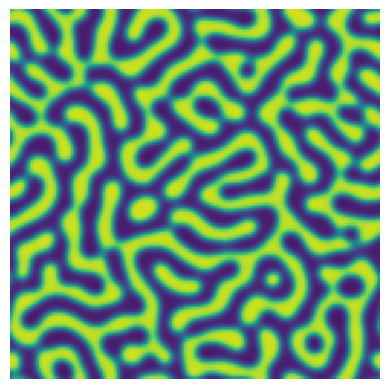

time = 120.0


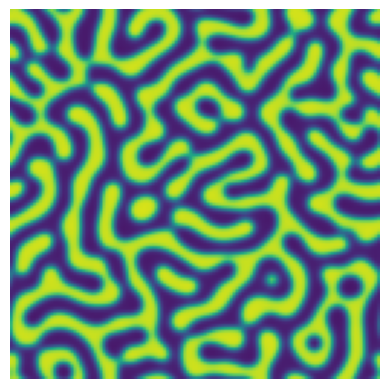

time = 140.0


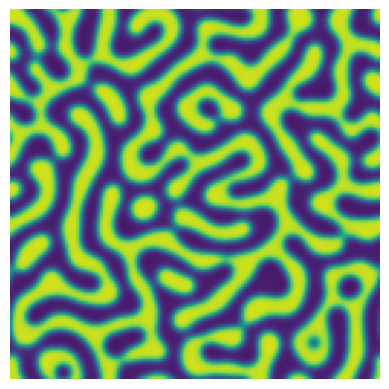

time = 160.0


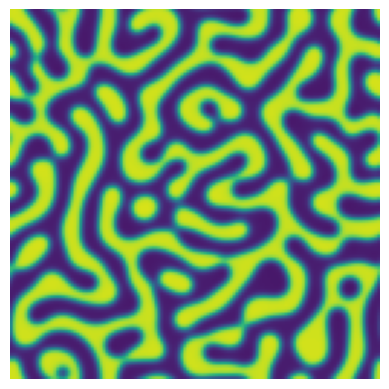

time = 180.0


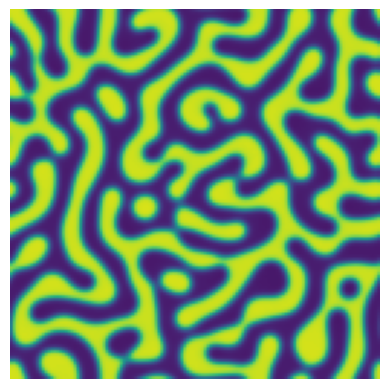

time = 200.0


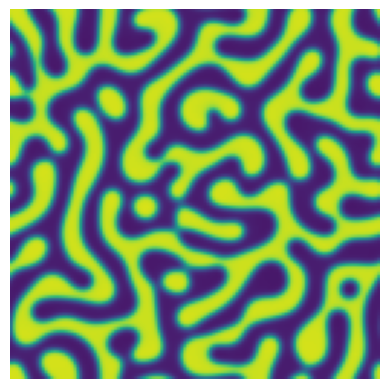


- <think>
Okay, the user wants to display an image using the Load_data_display_images tool. The file name provided is "PF_T1000.0_c0.5_dt0.02_No50". Let me check the function parameters.

The Load_data_display_images function requires a file name as a string. The user has already specified the file name, so I just need to pass that as the argument. The function will handle loading the data and displaying the images. I should make sure the file name is correctly formatted as a string. No other parameters are needed for this function. So the correct tool call is to use Load_data_display_images with the given file name.
</think>


- <think>
</think>

The image data has been successfully displayed using the file "PF_T1000.0_c0.5_dt0.02_No50". The process ended with status code 1, indicating success.


In [15]:
# Run the agent
messages = {
    "messages": [{"role": "user", "content": """The file name is "PF_T1000.0_c0.5_dt0.02_No50". 
                Display the image data by using the tool:'Load_data_display_images'."""}]
}
answer = agent.invoke(messages)
messages_list = answer["messages"] # Get the messages list
filtered_messages = [msg.content for msg in messages_list if isinstance(msg, AIMessage)] # Extract assistant messages only.
formatted_output = "\n- " + "\n- ".join(filtered_messages) # Formatted and output
print(formatted_output)


In [18]:
# Run the agent
messages = {
    "messages": [{"role": "user", "content": """Fix the index number to 1, fix the aging temperature at 1000 K, and fix the time step to 0.02. 
               Under the above conditions, repeat the tool: 'Save_phase_field_simulation_RSA' by changing the alloy composition 
               from 0.35 to 0.45 in increments of 0.05."""}]
}
answer = agent.invoke(messages)
messages_list = answer["messages"] # Get the messages list
filtered_messages = [msg.content for msg in messages_list if isinstance(msg, AIMessage)] # Extract assistant messages only.
formatted_output = "\n- " + "\n- ".join(filtered_messages) # Formatted and output
print(formatted_output)



- <think>
Okay, let's tackle this user query. The user wants to fix the index number to 1, set the aging temperature at 1000 K, and the time step to 0.02. Then, they want to repeat the 'Save_phase_field_simulation_RSA' tool by changing the alloy composition from 0.35 to 0.45 in increments of 0.05.

First, I need to understand the parameters required for the 'Save_phase_field_simulation_RSA' function. The parameters are index, aging_temp1, alloy_comp1, and time_step1. The user has specified index=1, aging_temp1=1000 K, time_step1=0.02, and alloy_comp1 should vary from 0.35 to 0.45 in steps of 0.05. 

So the alloy compositions will be 0.35, 0.35+0.05=0.40, 0.40+0.05=0.45. Wait, but 0.35 to 0.45 in increments of 0.05 would be three values: 0.35, 0.40, 0.45. Let me confirm that. Yes, because 0.35 + 0.05 = 0.40, then +0.05 is 0.45. So three different compositions.

For each of these compositions, I need to call the Save_phase_field_simulation_RSA function with the fixed parameters index=1,

time = 0.0


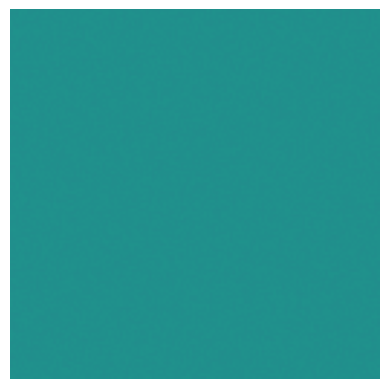

time = 20.0


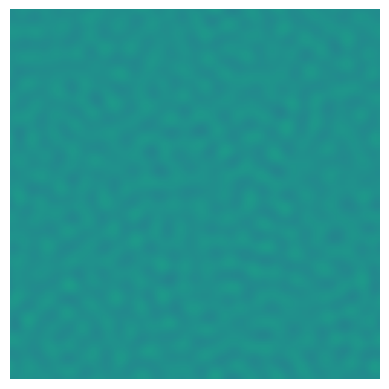

time = 40.0


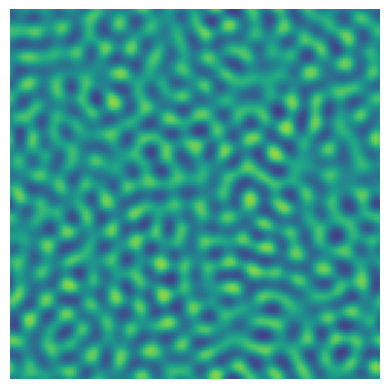

time = 60.0


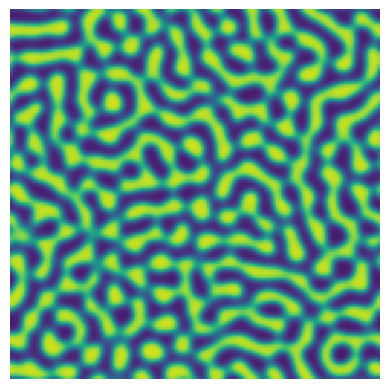

time = 80.0


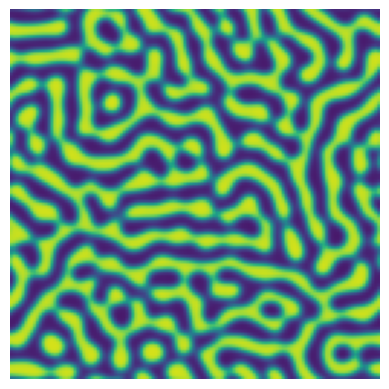

time = 100.0


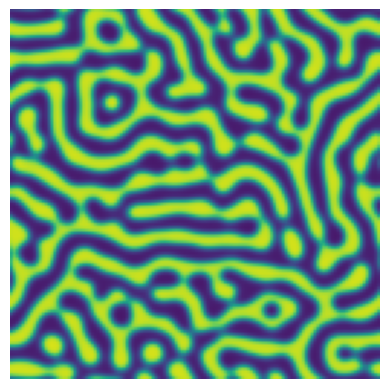

time = 120.0


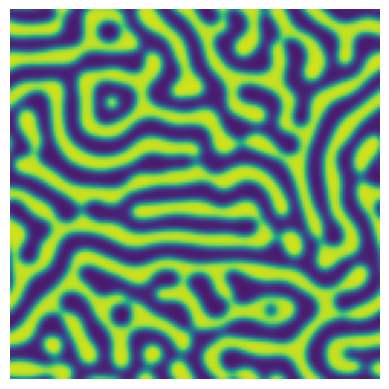

time = 140.0


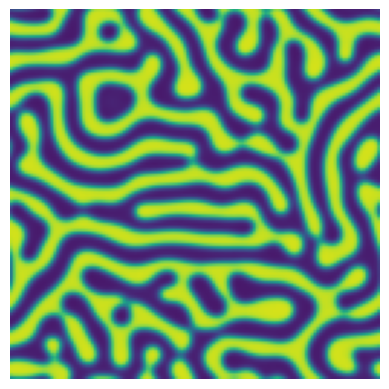

time = 160.0


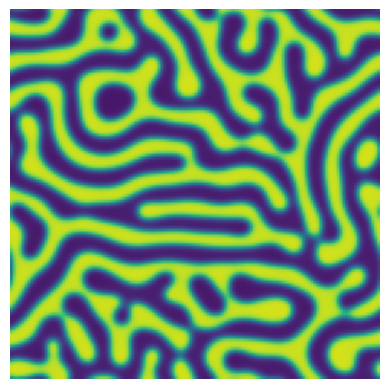

time = 180.0


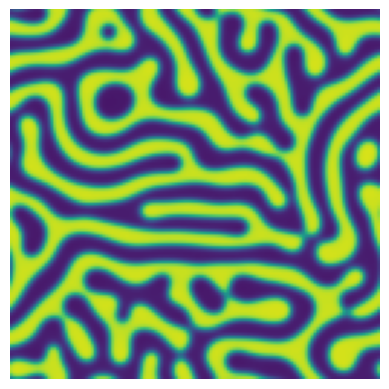

time = 200.0


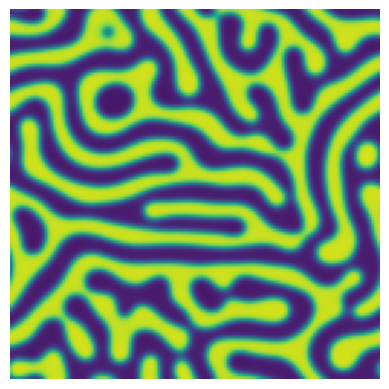


- <think>
Okay, the user wants to save image data using the 'Load_data_save_images' tool. The file name provided is "PF_T1000.0_c0.5_dt0.02_No3". Let me check the function parameters.

The Load_data_save_images function requires a file name as a string. The user has already specified the file name, so I just need to pass that as the argument. No other parameters are needed for this function. I should make sure the file name is correctly formatted as a string. The example given uses the exact file name, so I'll use that. The function should handle loading the data and saving the images. I don't see any other parameters required, so the tool call should be straightforward.
</think>


- <think>
Okay, the user wanted to save the image data using the Load_data_save_images tool with the file name "PF_T1000.0_c0.5_dt0.02_No3". I called the function with that file name, and the response was 1, which means the process succeeded. Now I need to inform the user that the images were saved successf

In [19]:
# Run the agent
messages = {
    "messages": [{"role": "user", "content": """The file name is "PF_T1000.0_c0.5_dt0.02_No3". 
                Save the image data by using the tool:'Load_data_save_images'."""}]
}
answer = agent.invoke(messages)
messages_list = answer["messages"] # Get the messages list
filtered_messages = [msg.content for msg in messages_list if isinstance(msg, AIMessage)] # Extract assistant messages only.
formatted_output = "\n- " + "\n- ".join(filtered_messages) # Formatted and output
print(formatted_output)
